# 🧠 Predictive Quality Control in Manufacturing
**complete AI-based Quality Control System** for a manufacturing process.  
It walks through every stage **data generation, model training, interpretability, and deployment** — to show how predictive analytics can be applied to industrial operations.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, 
                            confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

---

## 🏭 1. Synthetic Data Generation
We create realistic production data that reflects key process variables:

- `oven_temperature_c` – curing or baking temperature  
- `molding_pressure_bar` – pressure during molding  
- `line_speed_mpm` – conveyor or extrusion line speed  
- `tool_age_hours` – wear indicator of the tool or mold  
- `days_since_maintenance` – maintenance cycle indicator  
- `machine_vibration_hz` – vibration level (mechanical health)

Each record is labeled as:
> **1 = defective** | **0 = OK**

A hidden “true” rule defines defect probability:
> \( P(\text{defect}) = \sigma(\beta_0 + \sum_i \beta_i x_i) \)  
where \( \sigma(z) = \frac{1}{1 + e^{-z}} \)

---





In [2]:
# =====================================================
# 1. INDUSTRIAL PRODUCTION DATA
# =====================================================
print("=" * 70)
print("MANUFACTURING DEFECT DETECTION SYSTEM")
print("Case: Electronic Components Production Plant")
print("=" * 70)

np.random.seed(42)
n_samples = 2000

# Simulate sensor data from a production line
data = {
    # Machine parameters
    'oven_temperature_c': np.random.normal(220, 15, n_samples),
    'molding_pressure_bar': np.random.normal(150, 20, n_samples),
    'line_speed_mpm': np.random.normal(45, 5, n_samples),
    'ambient_humidity_pct': np.random.normal(45, 10, n_samples),
    
    # Material parameters
    'material_thickness_mm': np.random.normal(2.5, 0.3, n_samples),
    'material_strength_mpa': np.random.normal(350, 40, n_samples),
    
    # Operational parameters
    'cycle_time_sec': np.random.normal(12, 2, n_samples),
    'machine_vibration_hz': np.random.uniform(0.5, 3.5, n_samples),
    'tool_age_hours': np.random.uniform(0, 500, n_samples),
    
    # Context
    'shift': np.random.choice([1, 2, 3], n_samples),  # Morning, Afternoon, Night
    'operator_experience_years': np.random.randint(1, 20, n_samples),
    'days_since_maintenance': np.random.randint(1, 30, n_samples),
}

df = pd.DataFrame(data)

# Generate defect scores based on realistic conditions
defect_score = (
    0.15 * (df['oven_temperature_c'] - 220).abs() +
    0.10 * (df['molding_pressure_bar'] - 150).abs() +
    0.12 * df['machine_vibration_hz'] +
    0.08 * (df['tool_age_hours'] / 100) +
    0.05 * df['days_since_maintenance'] +
    -0.03 * df['operator_experience_years'] +
    np.random.normal(0, 2, n_samples)
)

# Around 5% defect rate (typical for high-quality manufacturing)
threshold = np.percentile(defect_score, 95)
df['defective'] = (defect_score > threshold).astype(int)

print(f"\nTotal parts produced: {len(df):,}")
print(f"Defective parts: {df['defective'].sum():,} ({df['defective'].mean():.2%})")
print(f"Non-defective parts: {(df['defective']==0).sum():,} ({(df['defective']==0).mean():.2%})")

MANUFACTURING DEFECT DETECTION SYSTEM
Case: Electronic Components Production Plant

Total parts produced: 2,000
Defective parts: 100 (5.00%)
Non-defective parts: 1,900 (95.00%)


---

## ⚙️ 2. Data Preparation
- Clean missing values, encode categorical variables (e.g., shift)
- Split data into **training (80%)** and **testing (20%)** sets
- Scale numerical features for better model convergence

---




In [4]:
# =====================================================
# 2. DATA PREPARATION
# =====================================================
X = df.drop('defective', axis=1)
y = df['defective']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\n📊 Data split:")
print(f"   Training: {len(X_train):,} parts")
print(f"   Test: {len(X_test):,} parts")


📊 Data split:
   Training: 1,500 parts
   Test: 500 parts


---

e
## 🧩 3. Model Traini## 🏭 1. Synthetic Data Generation
Wng (Logistic Regression)
We use **logistic regression**, a simple but powerful interpretable model:

\[
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}}
\]

- The coefficients (\( \beta_i \)) represent the **impact** of each variable.  
- Positive values increase defect risk; negative ones reduce it.

---

In [5]:
# =====================================================
# 3. MODEL TRAINING
# =====================================================
print("\n" + "=" * 70)
print("QUALITY CONTROL MODEL TRAINING")
print("=" * 70)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-validation (ROC-AUC):")
print(f"   Mean: {cv_scores.mean():.4f}")
print(f"   Std: {cv_scores.std():.4f}")

pipeline.fit(X_train, y_train)


QUALITY CONTROL MODEL TRAINING

Cross-validation (ROC-AUC):
   Mean: 0.5737
   Std: 0.0833


,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


---
## ✅ 4. Evaluation and Metrics
We assess performance with:
- **Accuracy, Precision, Recall, F1-score**
- **Confusion matrix**
- **ROC-AUC** (ability to separate good vs. defective parts)

These metrics help decide whether the model is production-ready.

---


In [6]:
# =====================================================
# 4. MODEL EVALUATION
# =====================================================
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n" + "=" * 70)
print("SYSTEM PERFORMANCE METRICS")
print("=" * 70)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (Correct Alarms)': precision_score(y_test, y_pred),
    'Recall (Defect Detection)': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

for metric, value in metrics.items():
    print(f"   {metric:.<40} {value:.4f}")

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n📋 Confusion Analysis:")
print(f"   ✓ True Negatives (Correct OK): {tn}")
print(f"   ✗ False Positives (False alarm): {fp}")
print(f"   ✗ False Negatives (Missed defect): {fn} ⚠️ CRITICAL")
print(f"   ✓ True Positives (Detected defect): {tp}")

# Economic impact example
cost_part = 50
inspection_cost = 5
customer_defect_cost = 500

potential_savings = (tp * customer_defect_cost) - (fp * inspection_cost)
undetected_defect_cost = fn * customer_defect_cost

print("\n💰 ESTIMATED ECONOMIC IMPACT:")
print(f"   Savings from detected defects: {tp * customer_defect_cost:,.0f} €")
print(f"   Cost of false alarms: {fp * inspection_cost:,.0f} €")
print(f"   Net savings: {potential_savings:,.0f} €")
print(f"   Cost of undetected defects: {undetected_defect_cost:,.0f} € ⚠️")

print("\n" + classification_report(y_test, y_pred, 
                                   target_names=['OK', 'Defective'],
                                   digits=4))



SYSTEM PERFORMANCE METRICS
   Accuracy................................ 0.5920
   Precision (Correct Alarms).............. 0.0547
   Recall (Defect Detection)............... 0.4400
   F1-Score................................ 0.0973
   ROC-AUC................................. 0.5048

📋 Confusion Analysis:
   ✓ True Negatives (Correct OK): 285
   ✗ False Positives (False alarm): 190
   ✗ False Negatives (Missed defect): 14 ⚠️ CRITICAL
   ✓ True Positives (Detected defect): 11

💰 ESTIMATED ECONOMIC IMPACT:
   Savings from detected defects: 5,500 €
   Cost of false alarms: 950 €
   Net savings: 4,550 €
   Cost of undetected defects: 7,000 € ⚠️

              precision    recall  f1-score   support

          OK     0.9532    0.6000    0.7364       475
   Defective     0.0547    0.4400    0.0973        25

    accuracy                         0.5920       500
   macro avg     0.5040    0.5200    0.4169       500
weighted avg     0.9083    0.5920    0.7045       500



---

## 🔍 5. Model Interpretation
We analyze coefficients to identify **critical quality factors**, e.g.:
- High temperature or tool wear → defect ↑  
- More operator experience → defect ↓  

This stage links data science with **process engineering knowledge**.

---

In [7]:
# =====================================================
# 5. RISK FACTOR ANALYSIS
# =====================================================
feature_importance = pd.DataFrame({
    'parameter': X.columns,
    'coefficient': pipeline.named_steps['classifier'].coef_[0],
    'impact': np.abs(pipeline.named_steps['classifier'].coef_[0])
}).sort_values('impact', ascending=False)

print("=" * 70)
print("RISK FACTORS FOR DEFECTS (ranked by importance)")
print("=" * 70)
print("\n🔴 Greatest impact on defects:")
for idx, row in feature_importance.head(5).iterrows():
    direction = "↑ Increases" if row['coefficient'] > 0 else "↓ Reduces"
    print(f"   {row['parameter']:.<35} {direction} risk (coef: {row['coefficient']:>7.4f})")

RISK FACTORS FOR DEFECTS (ranked by importance)

🔴 Greatest impact on defects:
   machine_vibration_hz............... ↑ Increases risk (coef:  0.3841)
   days_since_maintenance............. ↑ Increases risk (coef:  0.2760)
   material_strength_mpa.............. ↑ Increases risk (coef:  0.2582)
   operator_experience_years.......... ↓ Reduces risk (coef: -0.1892)
   cycle_time_sec..................... ↓ Reduces risk (coef: -0.1259)


---

## 📊 6. Visualization Dashboard
A set of professional visualizations enables interpretation and validation:

| Visualization | Purpose |
|----------------|----------|
| Confusion Matrix | Classification performance |
| ROC Curve | Detection ability |
| Feature Importance | Most influential parameters |
| Probability Distribution | Model confidence zones |
| Temperature vs Pressure | Process behavior mapping |
| Tool Age vs Defects | Preventive maintenance |
| Defects by Shift | Human or contextual patterns |

These plots make the system transparent and auditable.

---

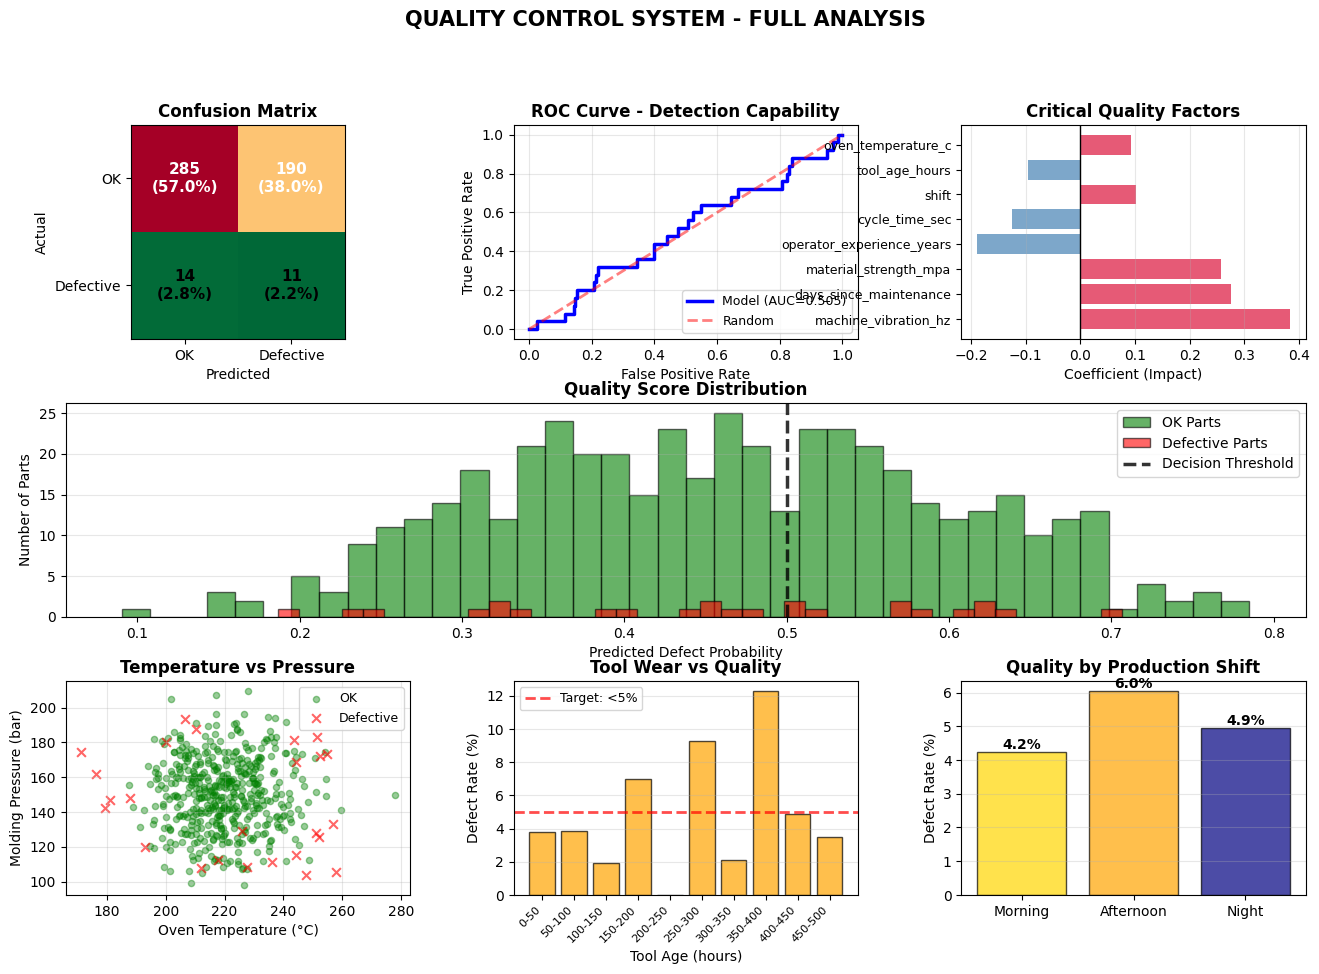

In [8]:
# =====================================================
# 6. VISUALIZATIONS
# =====================================================
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(cm, interpolation='nearest', cmap='RdYlGn_r')
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['OK', 'Defective'])
ax1.set_yticklabels(['OK', 'Defective'])
ax1.set_ylabel('Actual', fontsize=10)
ax1.set_xlabel('Predicted', fontsize=10)
for i in range(2):
    for j in range(2):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax1.text(j, i, f'{cm[i, j]}\n({cm[i, j]/cm.sum()*100:.1f}%)', 
                ha="center", va="center", color=color, fontsize=11, fontweight='bold')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, 'b-', linewidth=2.5, 
         label=f'Model (AUC={roc_auc_score(y_test, y_pred_proba):.3f})')
ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random', alpha=0.5)
ax2.set_xlabel('False Positive Rate', fontsize=10)
ax2.set_ylabel('True Positive Rate', fontsize=10)
ax2.set_title('ROC Curve - Detection Capability', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Feature Importance
ax3 = fig.add_subplot(gs[0, 2])
top_features = feature_importance.head(8)
colors = ['crimson' if x > 0 else 'steelblue' for x in top_features['coefficient']]
ax3.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['parameter'], fontsize=9)
ax3.set_xlabel('Coefficient (Impact)', fontsize=10)
ax3.set_title('Critical Quality Factors', fontsize=12, fontweight='bold')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.grid(True, alpha=0.3, axis='x')

# 4. Probability Distribution
ax4 = fig.add_subplot(gs[1, :])
ax4.hist(y_pred_proba[y_test == 0], bins=40, alpha=0.6, 
         label='OK Parts', color='green', edgecolor='black')
ax4.hist(y_pred_proba[y_test == 1], bins=40, alpha=0.6, 
         label='Defective Parts', color='red', edgecolor='black')
ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2.5, 
           label='Decision Threshold', alpha=0.8)
ax4.set_xlabel('Predicted Defect Probability', fontsize=10)
ax4.set_ylabel('Number of Parts', fontsize=10)
ax4.set_title('Quality Score Distribution', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Temperature vs Pressure
ax5 = fig.add_subplot(gs[2, 0])
test_data = X_test.copy()
test_data['defective'] = y_test.values
test_data['prediction'] = y_pred
ax5.scatter(test_data[test_data['defective']==0]['oven_temperature_c'], 
           test_data[test_data['defective']==0]['molding_pressure_bar'],
           c='green', alpha=0.4, s=20, label='OK')
ax5.scatter(test_data[test_data['defective']==1]['oven_temperature_c'], 
           test_data[test_data['defective']==1]['molding_pressure_bar'],
           c='red', alpha=0.6, s=40, marker='x', label='Defective')
ax5.set_xlabel('Oven Temperature (°C)', fontsize=10)
ax5.set_ylabel('Molding Pressure (bar)', fontsize=10)
ax5.set_title('Temperature vs Pressure', fontsize=12, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. Tool Age vs Defects
ax6 = fig.add_subplot(gs[2, 1])
bins = np.linspace(0, 500, 11)
defect_rate_by_tool_age = []
for i in range(len(bins)-1):
    mask = (test_data['tool_age_hours'] >= bins[i]) & \
           (test_data['tool_age_hours'] < bins[i+1])
    if mask.sum() > 0:
        defect_rate_by_tool_age.append(test_data[mask]['defective'].mean() * 100)
    else:
        defect_rate_by_tool_age.append(0)

ax6.bar(range(len(defect_rate_by_tool_age)), defect_rate_by_tool_age, 
        color='orange', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Tool Age (hours)', fontsize=10)
ax6.set_ylabel('Defect Rate (%)', fontsize=10)
ax6.set_title('Tool Wear vs Quality', fontsize=12, fontweight='bold')
ax6.set_xticks(range(len(bins)-1))
ax6.set_xticklabels([f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)], 
                     rotation=45, ha='right', fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')
ax6.axhline(y=5, color='red', linestyle='--', linewidth=2, label='Target: <5%', alpha=0.7)
ax6.legend(fontsize=9)

# 7. Defects by Shift
ax7 = fig.add_subplot(gs[2, 2])
shift_defects = test_data.groupby('shift')['defective'].agg(['sum', 'count', 'mean'])
shift_defects['rate'] = shift_defects['mean'] * 100
shifts = ['Morning', 'Afternoon', 'Night']
colors_shift = ['gold', 'orange', 'navy']
bars = ax7.bar(shifts, shift_defects['rate'], color=colors_shift, alpha=0.7, edgecolor='black')
ax7.set_ylabel('Defect Rate (%)', fontsize=10)
ax7.set_title('Quality by Production Shift', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')
for i, (bar, rate) in enumerate(zip(bars, shift_defects['rate'])):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('QUALITY CONTROL SYSTEM - FULL ANALYSIS', 
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

#
---

## ⚡ 7. Real-Time Evaluation Function
Defines a function that evaluates a new part during production:

- Takes sensor readings as input  
- Computes defect probability  
- Returns **alert levels** (🔴 Critical, 🟡 Warning, 🟢 Caution, ✅ Optimal)  
- Suggests **recommended actions**

Example output:

In [9]:
# =====================================================
# 7. REAL-TIME PRODUCTION FUNCTION
# =====================================================
def evaluate_production_part(part_params, model=pipeline, threshold=0.5):
    """
    Evaluates a single part in real-time during production.

    Args:
        part_params: dict with sensor readings
        model: trained model
        threshold: decision threshold (default 0.5)

    Returns:
        dict with decision and details
    """
    df_part = pd.DataFrame([part_params])
    prob = model.predict_proba(df_part)[0, 1]
    prediction = int(prob >= threshold)
    
    # Alert levels
    if prob >= 0.7:
        alert = "🔴 CRITICAL"
        action = "REJECT - Mandatory inspection"
    elif prob >= 0.5:
        alert = "🟡 WARNING"
        action = "Manual inspection recommended"
    elif prob >= 0.3:
        alert = "🟢 CAUTION"
        action = "Monitor parameters"
    else:
        alert = "✅ OPTIMAL"
        action = "Continue production"
    
    return {
        'predicted_defect': bool(prediction),
        'defect_probability': round(prob, 4),
        'alert_level': alert,
        'recommended_action': action,
        'model_confidence': round(abs(prob - 0.5) * 2, 2)
    }



---

## 🚀 8. Real-Time Simulation
We simulate real production scenarios:

| Part | Condition | Expected Outcome |
|------|------------|------------------|
| A1234 | Optimal parameters | ✅ Optimal |
| B5678 | High temperature | 🔴 Critical |
| C9012 | Worn tool | 🟡 Warning |

The system demonstrates **autonomous quality evaluation**, connecting data science models to industrial IoT systems.

---

## 💡 Integration Notes
For deployment in a factory setting:
- Connect to **SCADA/MES systems** for real-time data  
- Send alerts to **operators or maintenance systems**  
- Log decisions for **traceability and auditing**  
- Integrate with **SAP S/4HANA or SAP BTP IoT services** for enterprise insight  

---

### 🎯 Key Takeaways
- Logistic regression offers **interpretable AI** for industrial environments.  
- Synthetic data enables **safe experimentation** without real plant data.  
- Real-time functions bridge **AI models with operational systems**.  
- Visualization and interpretability make the system **trustworthy and explainable**.  

---

📘 **Keywords:** Predictive Quality, Industrial AI, Logistic Regression, Manufacturing Analytics, Real-Time Control, SAP S/4HANA Integration.


In [10]:
# =====================================================
# 8. REAL-TIME PRODUCTION SIMULATION
# =====================================================
print("\n" + "=" * 70)
print("REAL-TIME INSPECTION SIMULATION")
print("=" * 70)

# Example: 3 parts on the production line
example_parts = [
    {
        'name': 'Part #A1234 (Optimal Conditions)',
        'params': {
            'oven_temperature_c': 220,
            'molding_pressure_bar': 150,
            'line_speed_mpm': 45,
            'ambient_humidity_pct': 45,
            'material_thickness_mm': 2.5,
            'material_strength_mpa': 350,
            'cycle_time_sec': 12,
            'machine_vibration_hz': 1.0,
            'tool_age_hours': 50,
            'shift': 1,
            'operator_experience_years': 10,
            'days_since_maintenance': 5
        }
    },
    {
        'name': 'Part #B5678 (High Temperature)',
        'params': {
            'oven_temperature_c': 245,
            'molding_pressure_bar': 155,
            'line_speed_mpm': 48,
            'ambient_humidity_pct': 50,
            'material_thickness_mm': 2.6,
            'material_strength_mpa': 340,
            'cycle_time_sec': 11,
            'machine_vibration_hz': 2.8,
            'tool_age_hours': 420,
            'shift': 3,
            'operator_experience_years': 2,
            'days_since_maintenance': 25
        }
    },
    {
        'name': 'Part #C9012 (Worn Tool)',
        'params': {
            'oven_temperature_c': 218,
            'molding_pressure_bar': 148,
            'line_speed_mpm': 44,
            'ambient_humidity_pct': 48,
            'material_thickness_mm': 2.4,
            'material_strength_mpa': 345,
            'cycle_time_sec': 13,
            'machine_vibration_hz': 3.2,
            'tool_age_hours': 485,
            'shift': 2,
            'operator_experience_years': 15,
            'days_since_maintenance': 12
        }
    }
]

for part in example_parts:
    print(f"\n{'─' * 70}")
    print(f"🔍 {part['name']}")
    print(f"{'─' * 70}")
    
    result = evaluate_production_part(part['params'])
    
    print(f"   Status: {result['alert_level']}")
    print(f"   Defect Probability: {result['defect_probability']:.1%}")
    print(f"   Model Confidence: {result['model_confidence']:.1%}")
    print(f"   ➜ ACTION: {result['recommended_action']}")

print("\n" + "=" * 70)
print("✅ QUALITY CONTROL SYSTEM ACTIVE")
print("=" * 70)
print("\n📌 Recommended Integrations:")
print("   • SCADA/MES for real-time sensor data")
print("   • Alert system (email/SMS)")
print("   • Continuous monitoring dashboard")
print("   • Decision log for traceability")



REAL-TIME INSPECTION SIMULATION

──────────────────────────────────────────────────────────────────────
🔍 Part #A1234 (Optimal Conditions)
──────────────────────────────────────────────────────────────────────
   Status: ✅ OPTIMAL
   Defect Probability: 28.2%
   Model Confidence: 44.0%
   ➜ ACTION: Continue production

──────────────────────────────────────────────────────────────────────
🔍 Part #B5678 (High Temperature)
──────────────────────────────────────────────────────────────────────
   Status: 🔴 CRITICAL
   Defect Probability: 73.0%
   Model Confidence: 46.0%
   ➜ ACTION: REJECT - Mandatory inspection

──────────────────────────────────────────────────────────────────────
🔍 Part #C9012 (Worn Tool)
──────────────────────────────────────────────────────────────────────
   Status: 🟢 CAUTION
   Defect Probability: 44.5%
   Model Confidence: 11.0%
   ➜ ACTION: Monitor parameters

✅ QUALITY CONTROL SYSTEM ACTIVE

📌 Recommended Integrations:
   • SCADA/MES for real-time sensor data
 